# 번역기를 만들어보자

### 단어 단위의 번역기 만들기

In [1]:
import os
import pandas as pd
import numpy as np
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [2]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 194513


,eng,fra,cc
10812,I'll call them.,Je les appellerai.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
37141,Maybe it wasn't Tom.,Peut-être ne s'agissait-il pas de Tom.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
150244,"To tell the truth, I do not like him.","Franchement, je ne l'aime pas.",CC-BY 2.0 (France) Attribution: tatoeba.org #2...
171654,They jumped through a window into the river.,Ils sautèrent par une fenêtre dans la rivière.,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
156782,I want you to have my land after I die.,"Je veux qu'après ma mort, tu disposes de ma te...",CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [3]:
lines = lines[['eng', 'fra']][:50000] # 5만개 샘플 사용
lines.sample(5)

,eng,fra
37230,No one can help you.,Personne ne peut vous aider.
49388,I must be going blind.,Je dois devenir aveugle.
45610,Tom wrote the report.,Tom a écrit le rapport.
19001,I was distracted.,J'ai été distraite.
27761,You're just tired.,Tu es juste fatigué.


### Data Preprocessing

Applying Preprocessing to Data using Lambda fns 

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = sentence.split(" ")
    
    return sentence

In [5]:
def preprocess_sentence_decoder(sentence):
    sentence = sentence.lower().strip()
  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    
    sentence = sentence.strip()
    sentence = '\t ' + sentence + ' \n'
    sentence = sentence.split(" ")
    
    return sentence

In [6]:
lines.eng = lines.eng.apply(lambda x : preprocess_sentence(x))
lines.fra = lines.fra.apply(lambda x : preprocess_sentence_decoder(x))

English and French samples

In [7]:
lines.eng.sample(5)

9130              [we, re, baffled, .]
18893        [i, sat, at, the, bar, .]
48248    [he, looks, very, worried, .]
41131     [he, fired, three, shots, .]
44888      [they, started, dancing, .]
Name: eng, dtype: object

In [8]:
lines.fra.sample(5)

12861                    [\t, tu, es, voyante, ., \n]
36368                [\t, je, te, l, enverrai, ., \n]
44259    [\t, elle, r, para, ses, chaussettes, ., \n]
12270                 [\t, tom, est, innocent, ., \n]
34830            [\t, il, esp, rait, r, ussir, ., \n]
Name: fra, dtype: object

In [9]:
vocal_size = 500
eng_tokenizer = Tokenizer(char_level=False, num_words = vocal_size+1)
eng_tokenizer.fit_on_texts(lines.eng)
print(eng_tokenizer.texts_to_sequences(lines.eng))

[[32, 1], [32, 1], [32, 1], [1], [1], [237, 30], [237, 30], [237, 30], [237, 30], [237, 30], [237, 30], [237, 30], [237, 30], [237, 1], [237, 1], [237, 1], [237, 1], [237, 1], [237, 1], [237, 1], [237, 1], [53, 4], [30], [30], [30], [30], [30], [30], [30], [66, 30], [1], [1], [30], [1], [81, 30], [81, 30], [81, 30], [144, 30], [144, 30], [144, 30], [144, 1], [144, 1], [144, 1], [144, 1], [1], [1], [32, 46, 1], [32, 46, 1], [32, 46, 1], [30], [30], [2, 77, 1], [2, 77, 1], [2, 95, 1], [2, 96, 30], [2, 96, 30], [2, 96, 1], [39, 30], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [216, 4], [30], [30], [30], [220, 6, 1], [220, 6, 1], [220, 6, 1], [220, 6, 1], [30], [30], [30], [30], [106, 6, 1], [106, 6, 1], [47, 51, 1], [47, 51, 1], [47, 51, 1], [32, 61, 1], [32, 61, 1], [32, 61, 1], [72, 6, 30], [72, 6, 30], [72, 6, 30], [72, 6, 4], [72, 6, 4], [72, 6, 4], [40, 1], [40, 1], [18, 1], [18, 1], [2, 314, 1], [2, 314, 1], [2, 1], [2, 1], [2, 49, 1], [2, 154, 1], [2,

In [10]:
input_text = eng_tokenizer.texts_to_sequences(lines.eng)
input_text[:3]

[[32, 1], [32, 1], [32, 1]]

In [11]:
fra_tokenizer = Tokenizer(char_level=False)
fra_tokenizer.fit_on_texts(lines.fra)
target_text = fra_tokenizer.texts_to_sequences(lines.fra)

In [12]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [13]:
target_text[:5]

[[1, 93, 15, 2],
 [1, 471, 3, 2],
 [1, 933, 15, 2],
 [1, 934, 15, 2],
 [1, 934, 3, 2]]

Data Size Measurements

In [14]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 5958
프랑스어 단어장의 크기 : 9310


In [15]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 19


In [16]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기 : 5958
프랑스어 단어장의 크기 : 9310
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 19


In [17]:
sos_token = '\t'
eos_token = '\n'

encoder_input_2 = input_text
# 종료 토큰 제거
decoder_input_2 = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target_2 = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [18]:
encoder_input_2 = pad_sequences(encoder_input_2, maxlen = max_eng_seq_len, padding='post')
decoder_input_2 = pad_sequences(decoder_input_2, maxlen = max_fra_seq_len, padding='post')
decoder_target_2 = pad_sequences(decoder_target_2, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input_2))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input_2))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target_2))

영어 데이터의 크기(shape) : (50000, 8)
프랑스어 입력데이터의 크기(shape) : (50000, 19)
프랑스어 출력데이터의 크기(shape) : (50000, 19)


Padding

In [19]:
indices = np.arange(encoder_input_2.shape[0])
np.random.shuffle(indices)

encoder_input_2 = encoder_input_2[indices]
decoder_input_2 = decoder_input_2[indices]
decoder_target_2 = decoder_target_2[indices]

Training and Target Separation

In [20]:
n_of_val = 3000

encoder_input_train = encoder_input_2[:-n_of_val]
decoder_input_train = decoder_input_2[:-n_of_val]
decoder_target_train = decoder_target_2[:-n_of_val]

encoder_input_test = encoder_input_2[-n_of_val:]
decoder_input_test = decoder_input_2[-n_of_val:]
decoder_target_test = decoder_target_2[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(47000, 8)
(47000, 19)
(47000, 19)
(3000, 8)
(3000, 19)
(3000, 19)


### Encoder/Decoder Layers 만들기

In [21]:
encoder_inputs_2 = Input(shape=(None,))
# encoder embedding
enc_emb_2 = Embedding(eng_vocab_size, 256, input_length=max_eng_seq_len)(encoder_inputs_2)
enc_masking_2 = Masking(mask_value=0.0)(enc_emb_2)
encoder_lstm_2 = LSTM(units = 256, return_state = True)
encoder_outputs_2, state_h_2, state_c_2 = encoder_lstm_2(enc_masking_2)
encoder_states_2 = [state_h_2, state_c_2]

In [22]:
decoder_inputs_2 = Input(shape=(None,))
# decoder embedding
dec_emb_2 = Embedding(fra_vocab_size, 256)(decoder_inputs_2)
dec_masking_2 = Masking(mask_value=0.0)(dec_emb_2)
decoder_lstm_2 = LSTM(units = 256, return_sequences = True, return_state=True)
decoder_outputs_2, _, _= decoder_lstm_2(dec_masking_2, initial_state = encoder_states_2)

decoder_softmax_layer_2 = Dense(fra_vocab_size, activation='softmax')
decoder_outputs_2 = decoder_softmax_layer_2(decoder_outputs_2)

In [23]:
model = Model([encoder_inputs_2, decoder_inputs_2], decoder_outputs_2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1525248     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    2383360     input_2[0][0]                    
______________________________________________________________________________________________

In [24]:
model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy', metrics=['acc'])

Model Training

Epoch 1/10
1469/1469 [==============================] - 38s 21ms/step - loss: 1.3323 - acc: 0.7931 - val_loss: 1.0912 - val_acc: 0.8289

Epoch 00001: val_loss improved from inf to 1.09121, saving model to ./model/


INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


Epoch 2/10
1469/1469 [==============================] - 28s 19ms/step - loss: 0.9973 - acc: 0.8411 - val_loss: 0.9444 - val_acc: 0.8499

Epoch 00002: val_loss improved from 1.09121 to 0.94435, saving model to ./model/


INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


Epoch 3/10
1469/1469 [==============================] - 28s 19ms/step - loss: 0.8863 - acc: 0.8559 - val_loss: 0.8717 - val_acc: 0.8603

Epoch 00003: val_loss improved from 0.94435 to 0.87166, saving model to ./model/


INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


Epoch 4/10
1469/1469 [==============================] - 28s 19ms/step - loss: 0.8176 - acc: 0.8661 - val_loss: 0.8330 - val_acc: 0.8653

Epoch 00004: val_loss improved from 0.87166 to 0.83295, saving model to ./model/


INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


Epoch 5/10
1469/1469 [==============================] - 28s 19ms/step - loss: 0.7713 - acc: 0.8743 - val_loss: 0.8046 - val_acc: 0.8719

Epoch 00005: val_loss improved from 0.83295 to 0.80464, saving model to ./model/


INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


Epoch 6/10
1469/1469 [==============================] - 28s 19ms/step - loss: 0.7403 - acc: 0.8813 - val_loss: 0.7949 - val_acc: 0.8751

Epoch 00006: val_loss improved from 0.80464 to 0.79486, saving model to ./model/


INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


Epoch 7/10
1469/1469 [==============================] - 28s 19ms/step - loss: 0.7167 - acc: 0.8864 - val_loss: 0.7823 - val_acc: 0.8769

Epoch 00007: val_loss improved from 0.79486 to 0.78234, saving model to ./model/


INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


Epoch 8/10
1469/1469 [==============================] - 28s 19ms/step - loss: 0.6987 - acc: 0.8912 - val_loss: 0.7844 - val_acc: 0.8797

Epoch 00008: val_loss did not improve from 0.78234
Epoch 9/10
1469/1469 [==============================] - 28s 19ms/step - loss: 0.6867 - acc: 0.8953 - val_loss: 0.7832 - val_acc: 0.8805

Epoch 00009: val_loss did not improve from 0.78234
Epoch 10/10
1469/1469 [==============================] - 28s 19ms/step - loss: 0.6797 - acc: 0.8984 - val_loss: 0.7892 - val_acc: 0.8826

Epoch 00010: val_loss did not improve from 0.78234


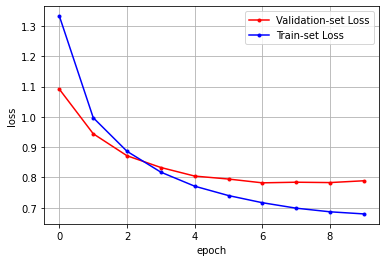

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy

model_path = './model/'
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                verbose=1, save_best_only=True)
cb_early_stopping = EarlyStopping(monitor='val_loss', patience=1000)

history = model.fit([encoder_input_train, decoder_input_train],decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 32, epochs = 10,callbacks=[cb_checkpoint, cb_early_stopping])

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 최종 epoch indicators 값

,Label,Loss,Accuracy,Val_loss,Val_accuracy
Indicators,Indicators,0.6797,0.8984,0.7892,0.8826


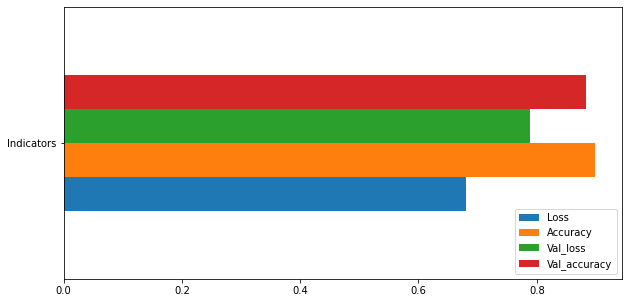

In [56]:
embedding_result_dict = {"Label":['Indicators'],"Loss":[0.6797],"Accuracy":[0.8984],"Val_loss":[0.7892],
                        "Val_accuracy":[0.8826]}    
embedding_result_df = pd.DataFrame(embedding_result_dict, index=['Indicators'])
embedding_result_df.plot.barh(figsize=(10,5))
embedding_result_df

In [27]:
encoder_model = Model(inputs = encoder_inputs_2, outputs = encoder_states_2)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         1525248   
_________________________________________________________________
masking (Masking)            (None, None, 256)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 2,050,560
Trainable params: 2,050,560
Non-trainable params: 0
_________________________________________________________________


In [28]:
decoder_state_input_h_2 = Input(shape=(256,))
decoder_state_input_c_2 = Input(shape=(256,))
decoder_states_inputs_2 = [decoder_state_input_h_2, decoder_state_input_c_2]

dec_emb_2 = Embedding(fra_vocab_size, 256)(decoder_inputs_2)
decoder_outputs_2, state_h_2, state_c_2 = decoder_lstm_2(dec_emb_2, initial_state = decoder_states_inputs_2)
decoder_states_2 = [state_h_2, state_c_2]

decoder_states_outputs_2 = decoder_softmax_layer_2(decoder_outputs_2)

In [29]:
decoder_model = Model(inputs=[decoder_inputs_2] + decoder_states_inputs_2, outputs=[decoder_outputs_2] + decoder_states_2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    2383360     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

In [30]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [31]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [32]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['\t']) and i!=fra2idx['\n']):
            temp = temp + idx2fra[i] + ' '
    return temp


In [33]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = fra2idx['\t']

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' ' + sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or 
            len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [34]:
for seq_index in [23,142,310,580,842]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: what about you ? 
정답 문장: et vous ? 
번역기가 번역한 문장:  pourquoi pas o o o pas
-----------------------------------
입력 문장: do you know who he is ? 
정답 문장: savez vous qui c est ? 
번역기가 번역한 문장:  peux une parler o 
-----------------------------------
입력 문장: don t make it . 
정답 문장: ne l empire pas ! 
번역기가 번역한 문장:  ceci f prends les le
-----------------------------------
입력 문장: how well off is tom ? 
정답 문장: quel est le niveau de vie de tom ? 
번역기가 번역한 문장:  lui 	 	 parler parle
-----------------------------------
입력 문장: who is it ? 
정답 문장: qui est il ? 
번역기가 번역한 문장:  lui lui maison as tou


In [35]:
from googletrans import Translator

# Translator 클래스 객체 선언 (translator라는 변수명은 마음대로 정해주면 됨)
translator = Translator()

In [55]:
print(translator.translate('do you know who he is ?', src='en', dest='ko'))

Translated(src=en, dest=ko, text=그가 누구인지 아십니까?, pronunciation=geuga nugu-inji asibnikka?, extra_data="{'confiden...")


In [54]:
print(translator.translate('peux une parler o', src='fr', dest='ko'))

Translated(src=fr, dest=ko, text=대화 할 수 있습니다, pronunciation=daehwa hal su issseubnida, extra_data="{'confiden...")


## Keras 임베딩층 사용하기 예제

In [38]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = ['nice great best amazing', 'stop lies', 'gorgeous beauty', 'painful teeth', 'supreme quality', 'bad', 'highly respectable']
y_train = [1, 0, 1, 0, 1, 0, 1]

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1
print('단어 집합 :',vocab_size)

단어 집합 : 16


In [40]:
X_encoded = tokenizer.texts_to_sequences(sentences)
print('정수 인코딩 결과 :',X_encoded)

정수 인코딩 결과 : [[1, 2, 3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13], [14, 15]]


In [41]:
max_len = max(len(l) for l in X_encoded)
print('최대 길이 :',max_len)

최대 길이 : 4


In [42]:
X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train = np.array(y_train)
print('패딩 결과 :')
print(X_train)

패딩 결과 :
[[ 1  2  3  4]
 [ 5  6  0  0]
 [ 7  8  0  0]
 [ 9 10  0  0]
 [11 12  0  0]
 [13  0  0  0]
 [14 15  0  0]]


In [43]:
from urllib.request import urlretrieve, urlopen
import gzip
import zipfile

urlretrieve("http://nlp.stanford.edu/data/glove.6B.zip", filename="glove.6B.zip")
zf = zipfile.ZipFile('glove.6B.zip')
zf.extractall() 
zf.close()

In [44]:
embedding_dict = dict()

f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    # 100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [45]:
print(embedding_dict['respectable'])
print('벡터의 차원 수 :',len(embedding_dict['respectable']))

[-0.049773   0.19903    0.10585    0.1391    -0.32395    0.44053
  0.3947    -0.22805   -0.25793    0.49768    0.15384   -0.08831
  0.0782    -0.8299    -0.037788   0.16772   -0.45197   -0.17085
  0.74756    0.98256    0.81872    0.28507    0.16178   -0.48626
 -0.006265  -0.92469   -0.30625   -0.067318  -0.046762  -0.76291
 -0.0025264 -0.018795   0.12882   -0.52457    0.3586     0.43119
 -0.89477   -0.057421  -0.53724    0.25587    0.55195    0.44698
 -0.24252    0.29946    0.25776   -0.8717     0.68426   -0.05688
 -0.1848    -0.59352   -0.11227   -0.57692   -0.013593   0.18488
 -0.32507   -0.90171    0.17672    0.075601   0.54896   -0.21488
 -0.54018   -0.45882   -0.79536    0.26331    0.18879   -0.16363
  0.3975     0.1099     0.1164    -0.083499   0.50159    0.35802
  0.25677    0.088546   0.42108    0.28674   -0.71285   -0.82915
  0.15297   -0.82712    0.022112   1.067     -0.31776    0.1211
 -0.069755  -0.61327    0.27308   -0.42638   -0.085084  -0.17694
 -0.0090944  0.1109     0.

In [46]:
embedding_matrix = np.zeros((vocab_size, 100))
print('임베딩 행렬의 크기(shape) :',embedding_matrix.shape)

임베딩 행렬의 크기(shape) : (16, 100)


In [47]:
print(embedding_dict['great'])

[-0.013786   0.38216    0.53236    0.15261   -0.29694   -0.20558
 -0.41846   -0.58437   -0.77355   -0.87866   -0.37858   -0.18516
 -0.128     -0.20584   -0.22925   -0.42599    0.3725     0.26077
 -1.0702     0.62916   -0.091469   0.70348   -0.4973    -0.77691
  0.66045    0.09465   -0.44893    0.018917   0.33146   -0.35022
 -0.35789    0.030313   0.22253   -0.23236   -0.19719   -0.0053125
 -0.25848    0.58081   -0.10705   -0.17845   -0.16206    0.087086
  0.63029   -0.76649    0.51619    0.14073    1.019     -0.43136
  0.46138   -0.43585   -0.47568    0.19226    0.36065    0.78987
  0.088945  -2.7814    -0.15366    0.01015    1.1798     0.15168
 -0.050112   1.2626    -0.77527    0.36031    0.95761   -0.11385
  0.28035   -0.02591    0.31246   -0.15424    0.3778    -0.13599
  0.2946    -0.31579    0.42943    0.086969   0.019169  -0.27242
 -0.31696    0.37327    0.61997    0.13889    0.17188    0.30363
 -1.2776     0.044423  -0.52736   -0.88536   -0.19428   -0.61947
 -0.10146   -0.26301  

In [48]:
for word, index in tokenizer.word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = embedding_dict.get(word)
    if vector_value is not None:
        embedding_matrix[index] = vector_value

In [49]:
embedding_matrix[2]

array([-0.013786  ,  0.38216001,  0.53236002,  0.15261   , -0.29694   ,
       -0.20558   , -0.41846001, -0.58437002, -0.77354997, -0.87866002,
       -0.37858   , -0.18516   , -0.12800001, -0.20584001, -0.22925   ,
       -0.42598999,  0.3725    ,  0.26076999, -1.07019997,  0.62915999,
       -0.091469  ,  0.70348001, -0.4973    , -0.77691001,  0.66044998,
        0.09465   , -0.44893   ,  0.018917  ,  0.33146   , -0.35021999,
       -0.35789001,  0.030313  ,  0.22253001, -0.23236001, -0.19719   ,
       -0.0053125 , -0.25848001,  0.58081001, -0.10705   , -0.17845   ,
       -0.16205999,  0.087086  ,  0.63028997, -0.76648998,  0.51618999,
        0.14072999,  1.01900005, -0.43136001,  0.46138   , -0.43584999,
       -0.47567999,  0.19226   ,  0.36065   ,  0.78987002,  0.088945  ,
       -2.78139997, -0.15366   ,  0.01015   ,  1.17980003,  0.15167999,
       -0.050112  ,  1.26259995, -0.77526999,  0.36030999,  0.95761001,
       -0.11385   ,  0.28035   , -0.02591   ,  0.31246001, -0.15

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

output_dim = 100

model = Sequential()
e = Embedding(vocab_size, output_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
1/1 - 1s - loss: 0.8351 - acc: 0.4286
Epoch 2/100
1/1 - 0s - loss: 0.8095 - acc: 0.4286
Epoch 3/100
1/1 - 0s - loss: 0.7844 - acc: 0.4286
Epoch 4/100
1/1 - 0s - loss: 0.7601 - acc: 0.4286
Epoch 5/100
1/1 - 0s - loss: 0.7365 - acc: 0.4286
Epoch 6/100
1/1 - 0s - loss: 0.7136 - acc: 0.4286
Epoch 7/100
1/1 - 0s - loss: 0.6914 - acc: 0.5714
Epoch 8/100
1/1 - 0s - loss: 0.6700 - acc: 0.7143
Epoch 9/100
1/1 - 0s - loss: 0.6493 - acc: 0.7143
Epoch 10/100
1/1 - 0s - loss: 0.6294 - acc: 0.7143
Epoch 11/100
1/1 - 0s - loss: 0.6102 - acc: 0.7143
Epoch 12/100
1/1 - 0s - loss: 0.5918 - acc: 0.8571
Epoch 13/100
1/1 - 0s - loss: 0.5740 - acc: 0.8571
Epoch 14/100
1/1 - 0s - loss: 0.5569 - acc: 0.8571
Epoch 15/100
1/1 - 0s - loss: 0.5405 - acc: 0.8571
Epoch 16/100
1/1 - 0s - loss: 0.5247 - acc: 1.0000
Epoch 17/100
1/1 - 0s - loss: 0.5096 - acc: 1.0000
Epoch 18/100
1/1 - 0s - loss: 0.4950 - acc: 1.0000
Epoch 19/100
1/1 - 0s - loss: 0.4809 - acc: 1.0000
Epoch 20/100
1/1 - 0s - loss: 0.4674 - a

회고. 단어 단위의 번역기를 만들어보았다.
<배운 점> 
* 엔코더와 디코더의 동작 개념에 대해 알게 되었다.
* 딥러닝과 어떤 관련이 있는지 대충 알 것 같다.
* 노트북만으로도 대단히 많은 어휘를 사용할 수 있음을 실감하였다.
* 모델 학습의 val_loss가 epoch가 진행됨에 따라 전반적으로 줄어들긴 했으나
  더 줄일 수 있는 방법을 찾고 싶다.
* 번역을 해 보니 완전 다른 경우도 있고 대충 맞는 경우도 있었다.
  정확한 경우는 없었던 것 같다.